# October 5, 2020

## Plotting heatmaps using wind extent data

### The problem with the wind extent data

The graphics I'd like to produce are based on a wind history chart; this graphic consists of a map shaded in different colors to show which areas experienced tropical storm-strength and hurricane-strength winds. As wind is one of the primary damaging effects of tropical cyclones (along with storm surge and flooding from precipitation), and because tropical cyclones can be many hundreds of miles in diameter, this information is significant in that it provides a more useful picture of the effects of a storm than the track of the center alone.

The problem lies in the fact that this shading requires filling a geometric area, whereas our data provides only radii in nautical miles for each of the four secondary directions. It is simple in theory to draw circumferences from these radii for each of the quadrants of a storm, but drawing this circular shape on the surface of a sphere, as on our map of the earth, requires some more computation as the physical distance (i.e., in nautical miles) that one degree of longitude spans changes based on latitude. 

After reading about various formulas dealing with this problem, such as the Haversine formula (and its inverse), I came upon [an implementation of formulas](http://www.geomidpoint.com/destination/calculation.html) that allows for calculation of distance and location from an initial bearing, among other things. It is this formula (based on the spherical Earth model) that I implemented to convert between nautical mile distances and the coordinate system.

In [1]:
# Our formula requires the radius of the Earth (approximated, based on spherical model)
RADIUS = 3440.1 # in this case, in Nautical Miles.


In [2]:
import os, sys
import pandas as pd

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

# Import relevant functions and libraries.
import numpy as np
import pandas as pd
import math as m
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from src.d07_visualization import storm_tracks as trk

# We'll use Irma as the example again.
irma = trk.stormID("IRMA", 2017)

# Import our data.
positions = pd.read_csv('../data/02_intermediate/Atlantic_positions.csv')
storms = pd.read_csv('../data/02_intermediate/Atlantic_storms.csv')

### Single storm wind history

There are two products I would like to produce based on wind history. The first shows the approximate maximum extents of the winds produced by a storm along the whole of its path, using different colors to represent hurricane-strength and tropical storm-strength winds.

The first step I want to take in producing this product is to draw the wind extents for a single point on the storm's path. This will allow me to ensure that the formula is producing a plausible result.

Before reading from the data, I'll manually take the extents from one quadrant of the storm and plug them into the formula. For the 12:00 update on September 8, 2017, from column 8 we see the NE Quadrant TS wind extent was 160 nautical miles, and the Hurricane wind extent was 60 nautical miles, with the center at 21.8N, 74.7W. I chose this update becasue the storm's wind extents were near their greatest at this time, which should make them easily visible on a map.

If we use one of these values in the formula, and trace over a sample of angles in the NE quadrant (my first instinct was to proceed counterclockwise from the "3 o'clock" position as radians typically are presented in this way, but after experimentation I see that the formula uses degrees proceeding clockwise from the "12 o'clock" position as is more traditional), we should see that our points basically outline the circumference of a quarter circle.

We can outline a circle by sampling several points along the circumference by taking the aforementioned sample of angles; at this scale, my assumption is that a sample of 31 angles per quadrant should be more than sufficient (e.g., every 3 degrees, minimum and maximum both included).

In [3]:
# We're going to use the data for Irma from September 8, 2017 at 12:00
columns = ["lat", "lon", "extNE34", "extSE34", "extSW34", "extNW34", "extNE64", "extSE64", "extSW64", "extNW64"]
positions[(positions["stormID"] == irma) & (positions["date"] == 20170908) & (positions["time"] == 1200)][columns]

,lat,lon,extNE34,extSE34,extSW34,extNW34,extNE64,extSE64,extSW64,extNW64


In [4]:
# For the Northeast Quadrant, TS winds is column 8, value 160
# Hurricane winds is column 16, value 60

# Scale the distance by the radius.
dist = 160
dist /= RADIUS

# Convert initial latitude and longitude to radians
lat = 21.8
lat *= (m.pi/180)
lon = -74.7
lon *= (m.pi/180)

# Create our sample of bearings, 31 angles (i.e. 0, 3, 6, 9, ..., 84, 87, 90)
ne_brngs = np.linspace(0, 90, 31)

# For each angle, we'll calculate the coordinates that are 160 nautical miles from
# our initial position.
for i in ne_brngs:
    # Convert the bearing to radians
    brng = i * (m.pi/180)
    # Calculate the final latitude and longitude
    dlat = m.asin(m.sin(lat)*m.cos(dist) + m.cos(lat)*m.sin(dist)*m.cos(brng))
    dlon = lon + m.atan2(m.sin(brng)*m.sin(dist)*m.cos(lat), m.cos(dist)-m.sin(lat)*m.sin(dlat))
    
    # Convert back from radians, and if the longitude is out of range 0, 360 (as is possible based on the 
    # formula), adjust by 360.
    dlat *= (180/m.pi)
    dlon *= (180/m.pi)
    if dlon < -180:
        dlon += 360
    elif dlon > 180:
        dlon -= 360
    
    # Print values to see if they could plausibly be outlining a circumference
    print(dlat, dlon)
        

24.464842511000604 -74.7
24.461118528885635 -74.5468353504483
24.4499574491821 -74.3941165257465
24.4313918332853 -74.24228779816586
24.40547582200138 -74.09179034394964
24.372284944116934 -73.94306071800663
24.331915850081366 -73.79652935553273
24.284485972458448 -73.6526191090086
24.23013311523708 -73.51174382858495
24.16901497449572 -73.37430699333743
24.101308593286717 -73.24070040026565
24.027209753940006 -73.11130291723461
23.94693231127844 -72.98647930532775
23.860707470486258 -72.86657911531263
23.76878301357626 -72.7519356621279
23.671422478560505 -72.6428650804975
23.568904295542534 -72.53966546398064
23.461520884019286 -72.44261608898549
23.349577715708126 -72.35197672452408
23.233392347202763 -72.26798702777585
23.11329342671369 -72.1908660248674
22.989619679067815 -72.12081167567261
22.862718873032687 -72.0580005208981
22.732946774896487 -72.00258740924582
22.600666092081074 -71.95470530204231
22.466245410395263 -71.914465152391
22.330058128354008 -71.88195585564026
22.192

Our values could very well be outlining a circle but it's hard to be sure until we plot it on a map. Let's try that.

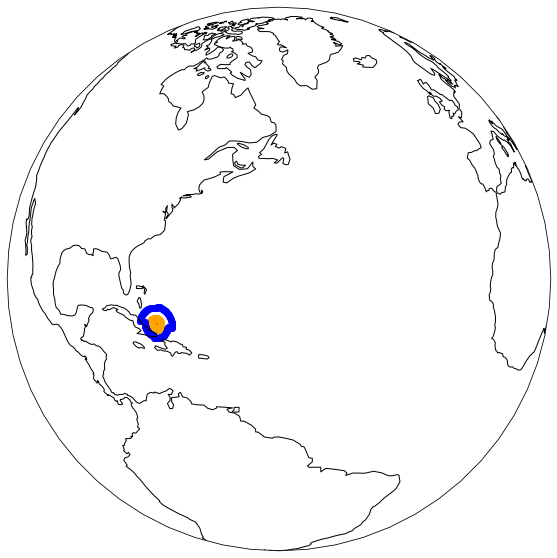

In [5]:
# Set projection
projection = ccrs.NearsidePerspective(central_longitude = -55, central_latitude = 30,  satellite_height = 10000000)
lon = np.linspace(-180, 180, 361) # changed from 179
lat = np.linspace(-90, 90, 181) # changed from 89
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = projection)
ax.set_global()
ax.coastlines()

# Take the Hurricane wind extents from our measurement, this time for each quadrant in turn, 
# moving clockwise from NE.
huext = [60, 50, 30, 55]

# Position of Center
lat = 21.8
lon = -74.7

# Plot just the center
ax.scatter(lon, lat, transform = ccrs.PlateCarree(), c = "red")

# Implement Formula
# Convert central coords to radians
lat *= (m.pi/180)
lon *= (m.pi/180)

# Create list of coordinate samples to iterate through, one for each quadrant.
# (One per quadrant because the distance of wind extent is given for each quadrant).
ne_brngs = np.linspace(0, 90, 31)
se_brngs = np.linspace(90, 180, 31)
sw_brngs = np.linspace(180, 270, 31)
nw_brngs = np.linspace(270, 360, 31)
brngs = [ne_brngs, se_brngs, sw_brngs, nw_brngs]

# Use quadrant number so we can use the integer result to iterate both the wind extent list and the bearing
# list.
for quad in range(4):
    
    # Scale distance by radius.
    dist = huext[quad] / RADIUS
    
    # For every sample angle, coordinate the final point and plot it.
    for i in brngs[quad]:
        brng = i * (m.pi/180)
        dlat = m.asin(m.sin(lat)*m.cos(dist) + m.cos(lat)*m.sin(dist)*m.cos(brng))
        dlon = lon + m.atan2(m.sin(brng)*m.sin(dist)*m.cos(lat), m.cos(dist)-m.sin(lat)*m.sin(dlat))
    
        dlat *= (180/m.pi)
        dlon *= (180/m.pi)
        if dlon < -180:
            dlon += 360
        elif dlon > 180:
            dlon -= 360
       
        ax.scatter(dlon, dlat, transform = ccrs.PlateCarree(), c = "orange")
        
# Take the tropical storm wind extents.
trext = [160, 120, 100, 150]

# Repeat the process for the tropical storm wind extents.
for quad in range(4):
    
    dist = trext[quad] / RADIUS
   
    for i in brngs[quad]:
        brng = i * (m.pi/180)
        dlat = m.asin(m.sin(lat)*m.cos(dist) + m.cos(lat)*m.sin(dist)*m.cos(brng))
        dlon = lon + m.atan2(m.sin(brng)*m.sin(dist)*m.cos(lat), m.cos(dist)-m.sin(lat)*m.sin(dlat))
    
        dlat *= (180/m.pi)
        dlon *= (180/m.pi)
        if dlon < -180:
            dlon += 360
        elif dlon > 180:
            dlon -= 360
       
        ax.scatter(dlon, dlat, transform = ccrs.PlateCarree(), c = "blue")

As expected, it's not as circular as we might hope because we lack the information needed to smoothly transition between quadrants, working only with the maximum wind extent for the entire quadrant. This won't be as much as an issue, I suspect, when using the heat map and 1-degree cells as the resolution will be so much lower it will mask any sizeable "jumps" or discontinuities in the circumference.

When we compare to the official NOAA/NWS wind field graphic for this same measurement (I expect the time difference is due to the dataset not accounting for Daylight Saving Time) we see this method at least allows us to produce a passable approximation of the wind field for the storm at a given point; if anything, our representation is an overestimate.

<img src='../readme_files/irma201709081100.png'></img>

Now the we have to use this rough circumference to populate the matrix we'll use for the heat map. For this first style of heat map, we'll set values for Hurricane-strength winds to 2, tropical storm-strength winds to 1, and all others 0.

The method I'm intending on implementing is to take each sample angle, find the resulting point on the circumference, then set the cell containing that point to the appropriate value, as well as the cell for every latitide between that cell and the horizontal (the latitude of the center). In this way, as we trace along the circumference we'll hit every longitude and fill in all the appropriate latitudes below it to fill in the entire quarter circle. I could also implement the inverse of this process, the same results will be achieved as long as one process or the other is used consistently.

In [6]:
# Create empty matrix for wind extents.
wind = np.zeros((180, 360))

In [7]:
# Still entering values by hand; take the coords of the center.
lat = 21.8
lon = -74.7

# Convert to radians.
rlat = lat*(m.pi/180)
rlon = lon*(m.pi/180)

# Create list of bearings (this could be a constant, implement later when modularizing)
ne_brngs = np.linspace(0, 90, 31)
se_brngs = np.linspace(90, 180, 31)
sw_brngs = np.linspace(180, 270, 31)
nw_brngs = np.linspace(270, 360, 31)
brngs = [ne_brngs, se_brngs, sw_brngs, nw_brngs]

# Tropical storm wind extents
trext = [160, 120, 100, 150]

# Iterate through each quadrant, implementing the formula
for quad in range(4):
    # Convert distance
    dist = trext[quad] / RADIUS
    # For each angle...
    for i in brngs[quad]:
        brng = i * (m.pi/180)
        dlat = m.asin(m.sin(rlat)*m.cos(dist) + m.cos(rlat)*m.sin(dist)*m.cos(brng))
        dlon = rlon + m.atan2(m.sin(brng)*m.sin(dist)*m.cos(rlat), m.cos(dist)-m.sin(rlat)*m.sin(dlat))
        # Calculate final coordinates and adjust if out of range
        dlat *= (180/m.pi)
        dlon *= (180/m.pi)
        if dlon < -180:
            dlon += 360
        elif dlon > 180:
            dlon -= 360
        
        # THEN, for the north quadrants, set the value for every cell on the longitude of the
        # final coordinates, between the center and the circumference (that is, values to the
        # South of the final value)
        if quad in [0, 3]:
            for y in range((90 + m.floor(lat)), (90 + m.ceil(dlat))):
                wind[y][180 + m.floor(dlon)] = 1
        # Same process but for the south quadrants, we set the values North of the final value.
        elif quad in [1, 2]:
            for y in range((90 + m.floor(dlat)), (90 + m.ceil(lat))):
                wind[y][180 + m.floor(dlon)] = 1

# Repeat the entire process again for Hurricane winds
huext = [60, 50, 30, 55]

for quad in range(4):
    
    dist = huext[quad] / RADIUS
   
    for i in brngs[quad]:
        brng = i * (m.pi/180)
        dlat = m.asin(m.sin(rlat)*m.cos(dist) + m.cos(rlat)*m.sin(dist)*m.cos(brng))
        dlon = rlon + m.atan2(m.sin(brng)*m.sin(dist)*m.cos(rlat), m.cos(dist)-m.sin(rlat)*m.sin(dlat))
    
        dlat *= (180/m.pi)
        dlon *= (180/m.pi)
        if dlon < -180:
            dlon += 360
        elif dlon > 180:
            dlon -= 360
        
        if quad  in [0, 3]:
            for y in range((90 + m.floor(lat)), (90 + m.ceil(dlat))):
                wind[y][180 + m.floor(dlon)] = 2
                
        elif quad in [1, 2]:
            for y in range((90 + m.floor(dlat)), (90 + m.ceil(lat))):
                wind[y][180 + m.floor(dlon)] = 2

# Mask zero values.
wind_transparent = np.ma.masked_equal(wind, 0)

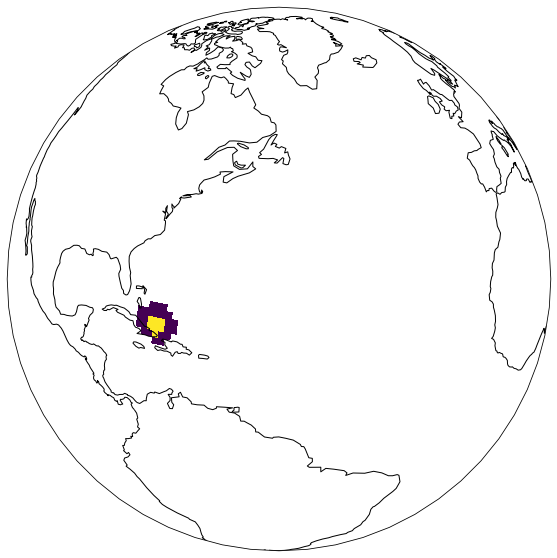

In [8]:
# Set Projection and plot our mesh
projection = ccrs.NearsidePerspective(central_longitude = -55, central_latitude = 30,  satellite_height = 10000000)
lon = np.linspace(-180, 180, 361) # changed from 179
lat = np.linspace(-90, 90, 181) # changed from 89
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = projection)
ax.set_global()
ax.coastlines()
ax.pcolormesh(Lon, Lat, wind_transparent, transform = ccrs.PlateCarree())

Good! This again seems like an adequate, if low-resolution, approximation of the wind field!

The last step will be to repeat this process for every step in the storm's path, and layer them onto the same map.

One additional bit of logic will be required to ensure that points indicated as experiencing hurricane-strength wind in a previous step which experience only tropical storm-strength wind in a later step are not set to values of 1; they should remain at 2 as we want to show a full wind *history*.

In [9]:
# We can first create a function that returns all of the wind extent columns for our storm of interest
# as lists within a list, as well as the status column indicating the strength of a storm (we only
# want to use rows where the storm is a TS or HU)

def winds(stormID, positions_df):
    # .tolist() the series.
    ts_ne = positions_df['extNE34'][positions_df['stormID'] == stormID].tolist()
    ts_se = positions_df['extSE34'][positions_df['stormID'] == stormID].tolist()
    ts_sw = positions_df['extSW34'][positions_df['stormID'] == stormID].tolist()
    ts_nw = positions_df['extNW34'][positions_df['stormID'] == stormID].tolist()
    
    hu_ne = positions_df['extNE64'][positions_df['stormID'] == stormID].tolist()
    hu_se = positions_df['extSE64'][positions_df['stormID'] == stormID].tolist()
    hu_sw = positions_df['extSW64'][positions_df['stormID'] == stormID].tolist()
    hu_nw = positions_df['extNW64'][positions_df['stormID'] == stormID].tolist()
    
    status = positions_df['status'][positions_df['stormID'] == stormID].tolist()
    
    return([status, ts_ne, ts_se, ts_sw, ts_nw, hu_ne, hu_se, hu_sw, hu_nw])

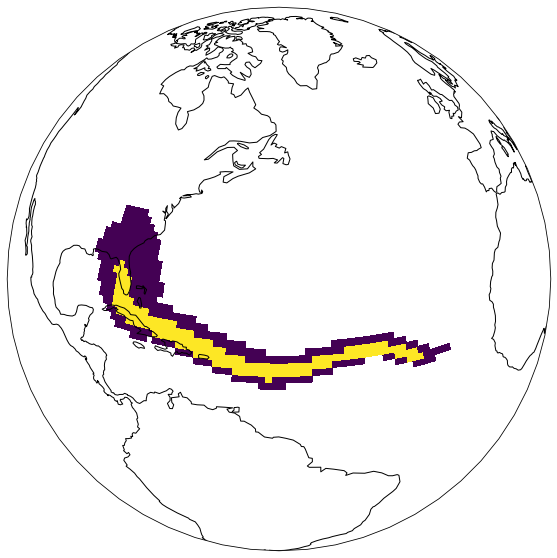

In [10]:
# Get the list of all of our coordinates, as well as the lists of wind extents
irma_lats = trk.track_lat(irma)
irma_lons = trk.track_lon(irma)
irma_winds = winds(irma, positions)

# Create empty matrix
wind_history = np.zeros((180, 360))

ne_brngs = np.linspace(0, 90, 31)
se_brngs = np.linspace(90, 180, 31)
sw_brngs = np.linspace(180, 270, 31)
nw_brngs = np.linspace(270, 360, 31)
brngs = [ne_brngs, se_brngs, sw_brngs, nw_brngs]

# For each pair of coordinates in the storm's history
for x in range(len(irma_lats)):
    
    # Get and convert to radians the center coordinates.
    lat = irma_lats[x]
    lon = irma_lons[x]
    rlat = lat*(m.pi/180)
    rlon = lon*(m.pi/180)
    # Pull out the correct wind values
    trext = [irma_winds[1][x], irma_winds[2][x], irma_winds[3][x], irma_winds[4][x]]
    huext = [irma_winds[5][x], irma_winds[6][x], irma_winds[7][x], irma_winds[8][x]]
    # If wind extents are missing for this row, skip to the next row.
    if -999 in trext:
        continue
    if -999 in huext:
        continue
    # If the storm is at least a tropical storm
    if irma_winds[0][x] in [' TS', ' HU']:
        # Implement the formula for the tropical storm wind extents
        for quad in range(4):
    
            dist = trext[quad] / RADIUS
   
            for i in brngs[quad]:
                brng = i * (m.pi/180)
                dlat = m.asin(m.sin(rlat)*m.cos(dist) + m.cos(rlat)*m.sin(dist)*m.cos(brng))
                dlon = rlon + m.atan2(m.sin(brng)*m.sin(dist)*m.cos(rlat), m.cos(dist)-m.sin(rlat)*m.sin(dlat))
    
                dlat *= (180/m.pi)
                dlon *= (180/m.pi)
                if dlon < -180:
                    dlon += 360
                elif dlon > 180:
                    dlon -= 360
            
                if quad in [0, 3]:
                    for y in range((90 + m.floor(lat)), (90 + m.ceil(dlat))):
                        # ONLY if the cell was not previously set to 2
                        if (wind_history[y][180 + m.floor(dlon)] != 2):
                            wind_history[y][180 + m.floor(dlon)] = 1

                elif quad in [1, 2]:
                    for y in range((90 + m.floor(dlat)), (90 + m.ceil(lat))):
                        # ONLY if the cell was not previously set to 2
                        if (wind_history[y][180 + m.floor(dlon)] != 2):
                            wind_history[y][180 + m.floor(dlon)] = 1
                            
    # If the storm is a hurricane
    if irma_winds[0][x] == ' HU':
        # Implement the formula again for the hurricane wind extents
        for quad in range(4):
    
            dist = huext[quad] / RADIUS
   
            for i in brngs[quad]:
                brng = i * (m.pi/180)
                dlat = m.asin(m.sin(rlat)*m.cos(dist) + m.cos(rlat)*m.sin(dist)*m.cos(brng))
                dlon = rlon + m.atan2(m.sin(brng)*m.sin(dist)*m.cos(rlat), m.cos(dist)-m.sin(rlat)*m.sin(dlat))
    
                dlat *= (180/m.pi)
                dlon *= (180/m.pi)
                if dlon < -180:
                    dlon += 360
                elif dlon > 180:
                    dlon -= 360
        
                if quad  in [0, 3]:
                    for y in range((90 + m.floor(lat)), (90 + m.ceil(dlat))):
                        wind_history[y][180 + m.floor(dlon)] = 2
                    
                elif quad in [1, 2]:
                    for y in range((90 + m.floor(dlat)), (90 + m.ceil(lat))):
                        wind_history[y][180 + m.floor(dlon)] = 2

# Mask the zero values            
wind_history_transparent = np.ma.masked_equal(wind_history, 0)

# And plot the result
projection = ccrs.NearsidePerspective(central_longitude = -55, central_latitude = 30,  satellite_height = 10000000)
lon = np.linspace(-180, 180, 361) # changed from 179
lat = np.linspace(-90, 90, 181) # changed from 89
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = projection)
ax.set_global()
ax.coastlines()
ax.pcolormesh(Lon, Lat, wind_history_transparent, transform = ccrs.PlateCarree())

# Note: Tropical Storm Winds in Purple, Hurricane in Yellow

We can compare this again to the official graphic and we see that we have a faithful representation of the wind history which overestimates wind extents at the borders (note in particular the protrusion at the Northwestern end of the path which suggests tropical storm-force winds were experienced much farther north, likely into Virginia, than the official graphic shows; likely this results from the center of the storm falling very near the northern boundary of one cell, causing the algorithm to flag the next one to the north as also experiencing the winds).

<img src='../readme_files/irmawh.png'></img>

Despite this overestimation, I'm pleased with this result particularly given the intended low resolution I set out to use. These issues could always be improved in the future by farther segmenting the map and using, for example, 0.5-degree by 0.5-degree cells.

### Heatmap of historic wind frequencies

The second product I hoped to produce is based on an aggregation of the data we produced in the prior function. By iterating through storms and repeating this process for each, we can produce a heatmap that shows the relative frequency by which different geographic areas experience winds produed by tropical cyclones.

While I would like to produce a variety of these graphics (for example: comparison between months, or using average storms per year as opposed to historical totals), I would like to begin by producing a graphic using the maximum amount of data available.

Because the wind extent data is only present in the HURDAT for storms 2004 and later, we have a fairly limited number of storms to work with, and the visualizations produced may be skewed because of this. However, they will only improve as additional seasons go by and the size of the data grows.

In the meanwhile, to conclude this investigation, I'll iterate through all storms since the 2004 season and total how many of them have produced tropical storm-force winds in each cell. Note that we must choose either tropical storm or hurricane winds for this representation as differentiating between both frequency and wind strength in the heatmap does not seem possible.

By producing a similar wind matrix as before for each storm, simply using values of 1 in cells where tropical storm winds or greater were produced, and 0 otherwise, then summing all the matrices, we can produce a sort of cumulative wind frequency for all Atlantic tropical cyclones since 2004.

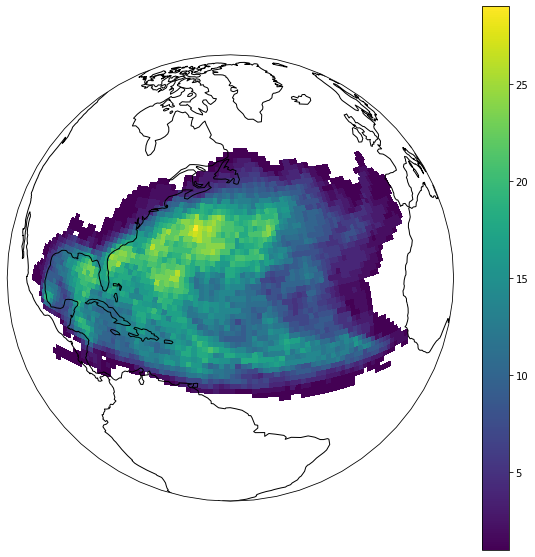

In [11]:
# Subset the data to use only storms from 2004 on
whstorms = storms['stormID'][storms['year'] >= 2004]
# Create an empty matrix to hold the cumulative totals.
cumulative_winds = np.zeros((180, 360))

# Bearing information
ne_brngs = np.linspace(0, 90, 31)
se_brngs = np.linspace(90, 180, 31)
sw_brngs = np.linspace(180, 270, 31)
nw_brngs = np.linspace(270, 360, 31)
brngs = [ne_brngs, se_brngs, sw_brngs, nw_brngs]

# Iterate through each storm
for storm in whstorms:
    # Get the coordinates and wind histories for the current storm.
    storm_lats = trk.track_lat(storm)
    storm_lons = trk.track_lon(storm)
    storm_winds = winds(storm, positions)

    # Create a matrix to hold its wind values.
    storm_history = np.zeros((180, 360))
    
    # For each coordinate the center of the storm passed over, implement the formula as described above.
    for x in range(len(storm_lats)):
    
        lat = storm_lats[x]
        lon = storm_lons[x]
        rlat = lat*(m.pi/180)
        rlon = lon*(m.pi/180)

        trext = [storm_winds[1][x], storm_winds[2][x], storm_winds[3][x], storm_winds[4][x]]
        huext = [storm_winds[5][x], storm_winds[6][x], storm_winds[7][x], storm_winds[8][x]]
    
        if (-999) in trext:
            continue
        if (-999) in huext:
            continue
            
        # This block is for Tropical Storm winds
        if storm_winds[0][x] in [' TS', ' HU']:
    
            for quad in range(4):
    
                dist = trext[quad] / RADIUS
   
                for i in brngs[quad]:
                    brng = i * (m.pi/180)
                    dlat = m.asin(m.sin(rlat)*m.cos(dist) + m.cos(rlat)*m.sin(dist)*m.cos(brng))
                    dlon = rlon + m.atan2(m.sin(brng)*m.sin(dist)*m.cos(rlat), m.cos(dist)-m.sin(rlat)*m.sin(dlat))
    
                    dlat *= (180/m.pi)
                    dlon *= (180/m.pi)
                    if dlon < -180:
                        dlon += 360
                    elif dlon > 180:
                        dlon -= 360
            
                    if quad in [0, 3]:
                        for y in range((90 + m.floor(lat)), (90 + m.ceil(dlat))):
                            if (storm_history[y][180 + m.floor(dlon)] != 2):
                                storm_history[y][180 + m.floor(dlon)] = 1

                    elif quad in [1, 2]:
                        for y in range((90 + m.floor(dlat)), (90 + m.ceil(lat))):
                            if (storm_history[y][180 + m.floor(dlon)] != 2):
                                storm_history[y][180 + m.floor(dlon)] = 1
                                
        # Commenting out the previous block and using this one instead will produce the same grahpic, but
        # for hurricane-force winds.
        '''
        if storm_winds[0][x] == ' HU':
    
            for quad in range(4):
    
                dist = huext[quad] / RADIUS
   
                for i in brngs[quad]:
                    brng = i * (m.pi/180)
                    dlat = m.asin(m.sin(rlat)*m.cos(dist) + m.cos(rlat)*m.sin(dist)*m.cos(brng))
                    dlon = rlon + m.atan2(m.sin(brng)*m.sin(dist)*m.cos(rlat), m.cos(dist)-m.sin(rlat)*m.sin(dlat))
    
                    dlat *= (180/m.pi)
                    dlon *= (180/m.pi)
                    if dlon < -180:
                        dlon += 360
                    elif dlon > 180:
                        dlon -= 360
        
                    if quad  in [0, 3]:
                        for y in range((90 + m.floor(lat)), (90 + m.ceil(dlat))):
                            storm_history[y][180 + m.floor(dlon)] = 2
                    
                    elif quad in [1, 2]:
                        for y in range((90 + m.floor(dlat)), (90 + m.ceil(lat))):
                            storm_history[y][180 + m.floor(dlon)] = 2
        '''
    # Add the storm's matrix to the cumulative one
    cumulative_winds += storm_history
           
# Mask zero values
cumulative_winds_transparent = np.ma.masked_equal(cumulative_winds, 0)

# Set projection and plot matrix
projection = ccrs.NearsidePerspective(central_longitude = -55, central_latitude = 30,  satellite_height = 10000000)
lon = np.linspace(-180, 180, 361) # changed from 179
lat = np.linspace(-90, 90, 181) # changed from 89
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = projection)
ax.set_global()
ax.coastlines()
mesh = ax.pcolormesh(Lon, Lat, cumulative_winds_transparent, transform = ccrs.PlateCarree())
# Add a scale
plt.colorbar(mesh)

I find this grahpic to be really very satisfying and intriguing. We can see a lot of interesting information in it; keeping in mind that this particular product holds only for storms since 2004, some of the relevant observations:
- The common starting location for classical "Cape Verde" storms is clearly visible off the coast of West Africa.
- The common path from Caribbean to Gulf storms is also present.
- The general curvature to the North and then East of the path of storms in the Central Atlatic is also visible.
- Some locations such as the coast of the Carolinas and the North Central Atlantic experienced upward of 25 storms producing tropical storm-strength winds or greater in the period since 2004.

Some additional graphics, as stated previously, that allow us to compare between months (across seasons) or years (between seasons) would be useful in drawing additional concusions, particularly in tandem with an empirical model (I'd like to look into spatially-weighted regression, next), but this feels like a very good starting point for deeper investigation.

## Modularizing
### winds() function and heatmap production

We can move the previously defined function for returning all wind extents, `winds()` to `storm_tracks.py` in `/src/d07_visualization`. We can include a constant link to the `positions` datframe as the default value for the `positions_df` argument.

We can additionally move the main body used to produce the cumulative frequency matrix into a function, `wind_frequency()` in the module `frequency.py` in `/src/d03_processing`. This will allow us to easily produce different frequency matrices by first subsetting the data that we pass in; as a default argument, it will use position data for all storms after 2004, but by first subsetting by months or hurricane season (year), we can produce individual graphics for each of these. Also, constants used in the formula such a lists of bearings and `RADIUS` can be defined here. Finally, there is an option to return frequencies only for hurricane-strength winds or greater.

Lastly, we can move the code for producing the wind history and heatmap themselves into functions called `wind_history()` and `heatmap()` in the `wind_history.py` module of `/src/d07_visualization`.